# Import necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.stats import entropy
from sklearn.decomposition import PCA
import torch.nn.functional as F

# Load the MNIST test images

In [2]:
def load_idx_images(file_path):
    with open(file_path, 'rb') as f:
        # Read magic number, number of images, rows, and columns
        magic_num = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        
        # Read image data
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        image_data = image_data.reshape(num_images, rows, cols)
        
    return image_data

file_path = '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_images = load_idx_images(file_path)

# Convert images to PyTorch tensor and normalize
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_images_tensor /= 255.0

# Print the shape of the loaded data
print("Shape of test images:", test_images_tensor.shape)


Shape of test images: torch.Size([10000, 28, 28])


# Define Autoencoder Architecture

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Define encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        # Define decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Sigmoid activation for output to scale between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Set device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Perform Random Search for Autoencoder

In [5]:
# Hyperparameters
encoding_dim_range = [16, 32, 64, 128]  # Range of encoding dimensions to try
learning_rate_range = [1e-3, 5e-4, 1e-4]  # Range of learning rates to try
num_epochs = 100


# Store losses
best_loss = float('inf')
best_hyperparams = None

for _ in range(10):  # Perform random search 10 times
    mse_losses = []  # Reset mse_losses for each iteration
    kl_losses = []   # Reset kl_losses for each iteration
    
    encoding_dim = np.random.choice(encoding_dim_range)
    learning_rate = np.random.choice(learning_rate_range)
    
    # Create DataLoader for training data
    train_loader = DataLoader(test_images_tensor, batch_size=128, shuffle=True)

    # Initialize autoencoder model
    Autoencoder_model = Autoencoder(encoding_dim).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(Autoencoder_model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        running_mse_loss = 0.0
        running_kl_loss = 0.0
        for data in train_loader:
            inputs = data.view(-1, 28*28).to(device)

            # Forward pass
            outputs = Autoencoder_model(inputs)

            # Compute MSE loss
            mse_loss = criterion(outputs, inputs)
            mse_loss = mse_loss.mean()  # Average over batch

            # Compute KL divergence
            kl_loss = entropy(inputs.cpu().detach().numpy().flatten(), outputs.cpu().detach().numpy().flatten())

            # Backward and optimize
            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

            running_mse_loss += mse_loss.item()
            running_kl_loss += kl_loss

        # Calculate average loss for the epoch
        epoch_mse_loss = running_mse_loss / len(train_loader)
        epoch_kl_loss = running_kl_loss / len(train_loader)
        mse_losses.append(epoch_mse_loss)
        kl_losses.append(epoch_kl_loss)
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_mse_loss/len(test_loader):.4f}')

    avg_loss = np.mean(mse_losses)  # Use MSE loss for evaluating best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_hyperparams = {'encoding_dim': encoding_dim, 'learning_rate': learning_rate}

print('Best Hyperparameters:', best_hyperparams)
print('Best Loss:', best_loss)
print('Training finished.')


Best Hyperparameters: {'encoding_dim': 64, 'learning_rate': 0.001}
Best Loss: 0.018357769236723078
Training finished.


# Evaluate Autoencoder

### Loss & KL divergence 

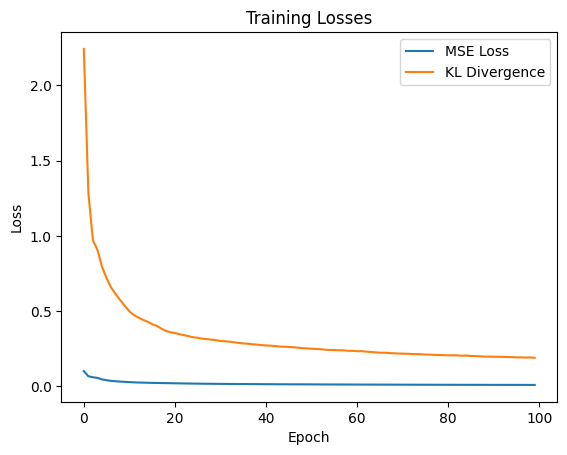

In [7]:
plt.plot(mse_losses, label='MSE Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

### Latent Space

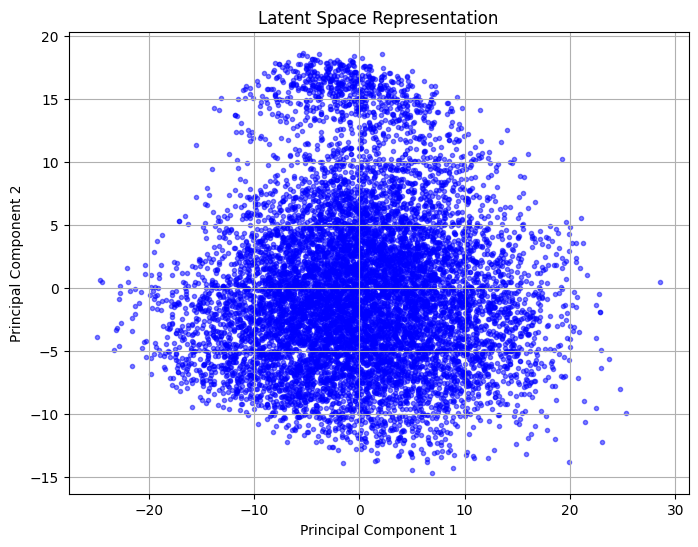

In [9]:
encoded_images = []
with torch.no_grad():
    for data in train_loader:
        inputs = data.view(-1, 28*28).to(device)
        encoded = Autoencoder_model.encoder(inputs)
        encoded_images.append(encoded.cpu().numpy())

# Concatenate encoded images
encoded_images = np.concatenate(encoded_images, axis=0)

# Perform PCA
pca = PCA(n_components=2)
latent_space = pca.fit_transform(encoded_images)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], marker='.', color='b', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Latent Space Representation')
plt.grid(True)
plt.show()


# Define VAE Architecture

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        # Latent space layers
        self.fc_mu = nn.Linear(128, 64)
        self.fc_logvar = nn.Linear(128, 64)
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Perform Random Search for VAE

In [11]:
# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Hyperparameters
encoding_dim_range = [16, 32, 64, 128]  # Range of encoding dimensions to try
learning_rate_range = [1e-3, 5e-4, 1e-4]  # Range of learning rates to try
num_epochs = 100

# Store losses
best_loss = float('inf')
best_hyperparams = None

for _ in range(10):  # Perform random search 10 times
    mse_losses = []  # Reset mse_losses for each iteration
    kl_losses = []   # Reset kl_losses for each iteration
    
    encoding_dim = np.random.choice(encoding_dim_range)
    learning_rate = np.random.choice(learning_rate_range)
    
    # Create DataLoader for training data
    train_loader = DataLoader(test_images_tensor, batch_size=128, shuffle=True)

    # Initialize VAE model
    VAE_model = VAE().to(device)

    # Define optimizer
    optimizer = optim.Adam(VAE_model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_kl_loss = 0.0
        for data in train_loader:
            inputs = data.view(-1, 28*28).to(device)

            # Forward pass
            recon_batch, mu, logvar = VAE_model(inputs)
            
            # Compute loss
            loss = vae_loss(recon_batch, inputs, mu, logvar)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_kl_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_kl_loss = running_kl_loss / len(train_loader)
        mse_losses.append(epoch_loss)
        kl_losses.append(epoch_kl_loss)
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, KL Divergence: {epoch_kl_loss:.4f}')

    avg_loss = np.mean(mse_losses)  # Use MSE loss for evaluating best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_hyperparams = {'encoding_dim': encoding_dim, 'learning_rate': learning_rate}

print('Best Hyperparameters:', best_hyperparams)
print('Best Loss:', best_loss)
print('Training finished.')


Best Hyperparameters: {'encoding_dim': 128, 'learning_rate': 0.001}
Best Loss: 15027.571059261274
Training finished.


# Evaluate VAE

### Loss & KL Divergence

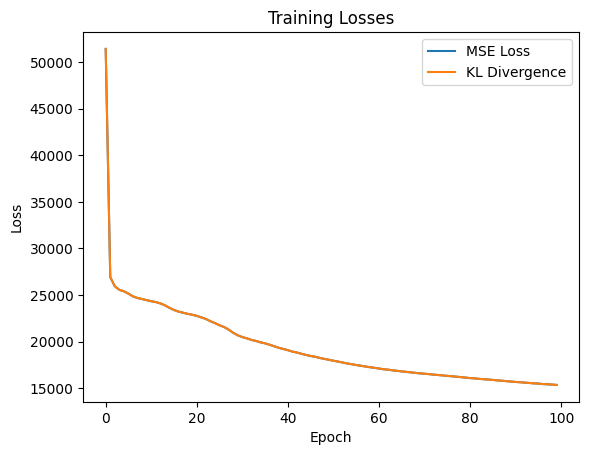

In [12]:
plt.plot(mse_losses, label='MSE Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

### Latent Space

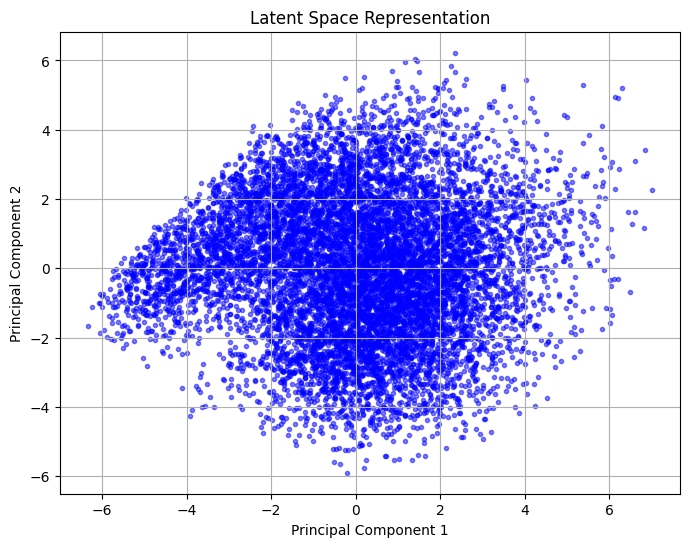

In [14]:
# Plot latent space using PCA
pca = PCA(n_components=2)

# Encode test images
encoded_images = []
with torch.no_grad():
    for data in train_loader:
        inputs = data.view(-1, 28*28).to(device)
        encoded = VAE_model.encoder(inputs)
        encoded_images.append(encoded.cpu().numpy())

# Concatenate encoded images
encoded_images = np.concatenate(encoded_images, axis=0)

# Perform PCA
latent_space = pca.fit_transform(encoded_images)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], marker='.', color='b', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Latent Space Representation')
plt.grid(True)
plt.show()